<a href="https://colab.research.google.com/github/JF473/machinelearninglab3/blob/main/INF2008_Lab03_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 03: Data Preparation for Modeling (Classification)

**CRISP-DM Focus: Data Preparation (DP) + Modeling + Evaluation**

In this lab, **modeling is used only as a measurement tool**. We will do a simple short model iteration to get us used to the entire Machine Learning cycle. We will also **not** hypertune models. We will carry out feature engineering (data preparation step), run a simple decision tree model and evaluate the accuracy to test if that improvement mattered.

Dataset: Titanic (Kaggle)  
Target: `Survived` (0 / 1)

---



## Learning Outcomes

By the end of this lab, you should be able to:
1. Apply a **structured data preparation workflow** aligned to CRISP-DM.
2. Distinguish clearly between **Data Understanding**, **Data Preparation**, and **Modeling**.
3. Prepare data safely for a **Decision Tree classifier**.
4. Explain why a preparation decision changes (or does not change) model performance.
5. Identify where data leakage could occur.



## The Role of Modeling in This Lab

In CRISP-DM, Modeling and Evaluation are full phases.

In this lab, we will not cover them in full because we are using them to guide us to answer the question:

> **Did our Data Preparation decisions make the data more learnable?**

Therefore we will:
- use **one simple model** (Decision Tree)
- use **one metric** (accuracy + confusion matrix)
- avoid tuning, optimisation, and model comparison (these will be covered in subsequent labs)

## 0. Environment Setup

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
RANDOM_STATE = 42




---

> Why do we set RANDOM_STATE = 42?
>
> Many steps in machine learning involve randomness, even when the code looks deterministic. Eg if there is a tie in a decision tree split.
>
> If we do not control randomness, then two students running the same notebook with the same code on the same dataset can get different accuracy values.
>
> Hence setting the random state ensures reproducibility in:
>* the same train/test split
>* the same random decisions inside the model
>* the same results when nothing else changes
>
> If randomness changes between runs, the accuracy may go up or down even if data preparation did not change and students may draw incorrect conclusions
>
>
> By fixing RANDOM_STATE, we make sure that the only thing that changes is the data preparation step and this makes the modeling loop reproducible.

---




## 1. Dataset Loading and Scope

Place Kaggle's `train.csv` in the same directory as this notebook.


In [2]:

if not os.path.exists("train.csv"):
    raise FileNotFoundError("Please place Kaggle Titanic train.csv in the same folder as this notebook.")

df = pd.read_csv("train.csv")
print("shape:", df.shape)
df.head()


shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



## 2. Data Understanding Checkpoint (DU)

Recall  in Lab 01, one of the key items here is explictly showing the datatype of each variable, and also finding out missing values, possible leakages etc.

You can get the columns for the following:

In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name               str
Sex                str
Age            float64
SibSp            int64
Parch            int64
Ticket             str
Fare           float64
Cabin              str
Embarked           str
dtype: object

In [4]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Exercise DU-1

Please fill up the following table:


| column_name  | role        | type       |
|--------------|-------------|------------|
| PassengerId  |  |    |
| Survived     |  |    |
| Pclass       |  |    |
| Name         |  |    |
| Sex          |  |    |
| Age          |  |    |
| SibSp        |  |    |
| Parch        |  |    |
| Ticket       |  |    |
| Fare         |  |    |
| Cabin        |  |    |
| Embarked     |  |    |


In [5]:
list(df.columns)

import pandas as pd

du_table = pd.DataFrame({
    "column_name": [
        "PassengerId", "Survived", "Pclass", "Name", "Sex", "Age",
        "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"
    ],
    "role": [
        "Identifier",
        "Target",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature",
        "Feature"
    ],
    "type": [
        "Integer (ID)",
        "Binary (categorical)",
        "Ordinal categorical",
        "Text",
        "Categorical (nominal)",
        "Numerical (continuous)",
        "Numerical (discrete)",
        "Numerical (discrete)",
        "Categorical (string)",
        "Numerical (continuous)",
        "Categorical (string)",
        "Categorical (nominal)"
    ]
})

du_table

,column_name,role,type
0,PassengerId,Identifier,Integer (ID)
1,Survived,Target,Binary (categorical)
2,Pclass,Feature,Ordinal categorical
3,Name,Feature,Text
4,Sex,Feature,Categorical (nominal)
5,Age,Feature,Numerical (continuous)
6,SibSp,Feature,Numerical (discrete)
7,Parch,Feature,Numerical (discrete)
8,Ticket,Feature,Categorical (string)
9,Fare,Feature,Numerical (continuous)


### Exercise DU-2

Check the missing values per column.

In [6]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
unique_values = df.nunique()

missing_df = pd.DataFrame({
    'nunique': unique_values,
    'missing_count': missing_values,
    'missing_pct': missing_percentage
})

missing_df = missing_df.sort_values(by='missing_count', ascending=False)
missing_df

,nunique,missing_count,missing_pct
Cabin,147,687,77.104377
Age,88,177,19.865320
Embarked,3,2,0.224467
PassengerId,891,0,0.000000
Name,891,0,0.000000
Pclass,3,0,0.000000
Survived,2,0,0.000000
Sex,2,0,0.000000
Parch,7,0,0.000000
SibSp,7,0,0.000000


### Exercise DU-3

Plot the target distribution for `Survived`.

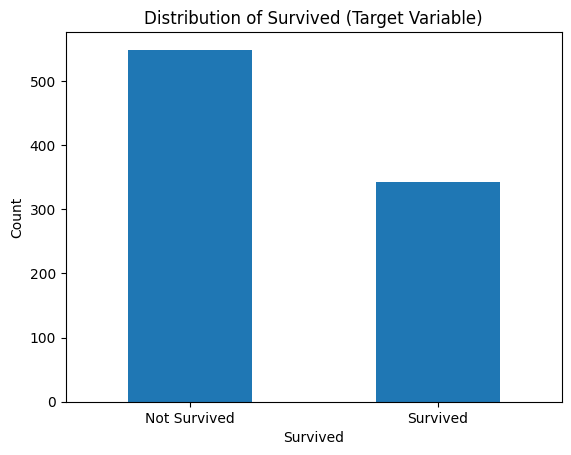

In [7]:
df['Survived'].value_counts().plot(kind='bar', title='Distribution of Survived (Target Variable)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Survived', 'Survived'], rotation=0)
plt.show()


**Suggested observations (example):**
- Some important columns have missing values (commonly `Age`, `Cabin`, sometimes `Embarked`).
- Several columns are categorical strings and will require encoding.
- Some columns are identifiers/text-heavy and should be excluded in DP1 to keep the lab focused.



## Data Preparation Framework (DP Stages)

We follow five stages:

- **DP1 – Select**: choose what features are allowed (remove IDs/leakage/noise)
- **DP2 – Clean**: handle missing/invalid values
- **DP3 – Structure**: encode categoricals; ensure numeric inputs
- **DP4 – Construct**: You are allowed to rearrange information you already have, but you are not allowed to create new information.
- **DP5 – Validate**: split correctly; fit preprocessing on train only

DP4 is intentionally narrow (to avoid confusion)
In this lab, you may combine or simplify existing columns
if the result still clearly represents the same real-world idea. You should not create features that only make sense because of the model. For instance:
1. **No new information** (only recombine existing columns)
2. **Human-interpretable meaning** (explainable without referencing a model)
3. **Model-agnostic** (should make sense before choosing the model)

For example:
*   `FamilySize = SibSp + Parch + 1`

Note:
*   SibSp  = family members (siblings/spouse)
*   Parch  = family members (parents/children)
*   1    = the passenger themselves


## 3. DP1 – Select (Feature Scoping)

We will use a compact, interpretable feature set.

**Keep:**
- Numerical: `Age`, `Fare`, `SibSp`, `Parch`
- Categorical: `Sex`, `Pclass`, `Embarked`

**Drop initially:**
`PassengerId`, `Name`, `Ticket`, `Cabin`.

### Exercise DP-1.1

Create `X` and `y` using only the selected columns.


In [8]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = df[features]
y = df[target]

# Display the head of X as requested by the original notebook prompt for this cell
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S



## 4. Modelling & Evaluation Loop (Baseline)

Here we use a simple model early only to measure the effect of data preparation not to perform modelling. This is very important!

This is a baseline with:
- Train/test split
- Simple imputation + one-hot encoding
- Decision Tree (depth limited for interpretability)

### Exercise DP-1.2

Build a pipeline that:
- imputes numeric with median
- imputes categorical with most frequent
- one-hot encodes categoricals
- trains a decision tree (`max_depth=3`)

Report:
- accuracy
- confusion matrix

It is important that no additional feature engineering work should be done here. The purpose here is to get an accuracy floor.

Accuracy: 0.7989

Confusion Matrix:
[[92 13]
 [23 51]]


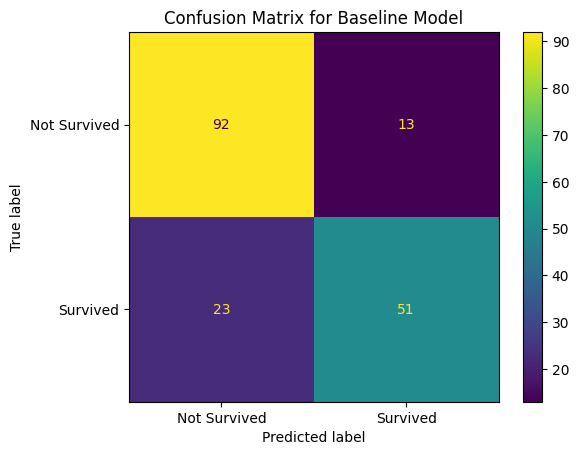


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [9]:
# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Identify numerical and categorical features for preprocessing
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 2. Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. Create the full pipeline with a Decision Tree Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# 4. Report accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Display confusion matrix visually
cmd_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Survived', 'Survived'])
cmd_display.plot()
plt.title('Confusion Matrix for Baseline Model')
plt.show()

# Optional: Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


## 5. DP2 – Clean

The above code inputed values quite randomly to build the baseline accuracy floor.

In this stage we want to be more explicit and decide:
* Should missing values be filled or dropped?
* If filled, how? Mean, median, mode?
* Does missing values itself carry meaning?

These decisions are made once and documented.

In [10]:
# Re-evaluating missing values, including empty strings and whitespace for object columns
print("Re-evaluating missing values (including empty strings/whitespace for object columns):")
df_cleaned_check = df.copy()

# For object columns, replace empty strings/whitespace with NaN for a robust missing check
for col in df_cleaned_check.select_dtypes(include='object').columns:
    df_cleaned_check[col] = df_cleaned_check[col].replace(r'^\s*$', np.nan, regex=True)

missing_values_robust = df_cleaned_check.isnull().sum()
missing_percentage_robust = (df_cleaned_check.isnull().sum() / len(df_cleaned_check)) * 100

missing_df_robust = pd.DataFrame({
    'nunique': df_cleaned_check.nunique(),
    'missing_count_robust': missing_values_robust,
    'missing_pct_robust': missing_percentage_robust
})

missing_df_robust = missing_df_robust.sort_values(by='missing_count_robust', ascending=False)
print(missing_df_robust)

print("\n-- Decision considerations for columns with missing values --")

# Embarked: Inspect unique values and decide imputation (most frequent)
print("\nEmbarked column details (original df for raw values):")
print(df['Embarked'].value_counts(dropna=False)) # Check original df for raw values before any replacement
print("Decision: For 'Embarked', with only 2 missing values, imputation with the most frequent category is appropriate.")

# Age: Inspect distribution (median imputation)
print("\nAge column details:")
print(df['Age'].describe())
print("Decision: For 'Age', given its numerical nature and potential skewness, imputation with the median is a robust choice.")

# Cabin: High missing percentage (decision is usually to drop or complex feature engineering)
print("\nCabin column details (top 5 value counts):")
print(df['Cabin'].value_counts(dropna=False).head())
print("Decision: With ~77% missing values, 'Cabin' is a candidate for dropping for simpler models, or requires more advanced feature engineering (e.g., extracting the first letter or creating a 'has_cabin' indicator feature). For now, we acknowledge its high missingness.")

Re-evaluating missing values (including empty strings/whitespace for object columns):
             nunique  missing_count_robust  missing_pct_robust
Cabin            147                   687           77.104377
Age               88                   177           19.865320
Embarked           3                     2            0.224467
PassengerId      891                     0            0.000000
Name             891                     0            0.000000
Pclass             3                     0            0.000000
Survived           2                     0            0.000000
Sex                2                     0            0.000000
Parch              7                     0            0.000000
SibSp              7                     0            0.000000
Fare             248                     0            0.000000
Ticket           681                     0            0.000000

-- Decision considerations for columns with missing values --

Embarked column details (origin

C:\Users\mastu\AppData\Local\Temp\ipykernel_25380\687989797.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df_cleaned_check.select_dtypes(include='object').columns:


This calculates the missing values. But it does ignore empty cells, or cells with blanks / spaces. Lets try to include them in as well.

In [11]:
# Replace empty/whitespace-only strings with NaN for object columns and re-compute missing counts
obj_cols = df.select_dtypes(include='object').columns

# Count blank-only entries before replacement
blank_counts = {col: df[col].apply(lambda x: isinstance(x, str) and x.strip() == '').sum() for col in obj_cols}

# Create a copy and replace blanks with NaN
df_blank_clean = df.copy()
df_blank_clean[obj_cols] = df_blank_clean[obj_cols].replace(r'^\s*$', np.nan, regex=True)

# Recompute missing statistics including blanks treated as NaN
nunique = df_blank_clean.nunique()
missing_count = df_blank_clean.isnull().sum()
missing_pct = df_blank_clean.isnull().mean() * 100

missing_df_blank = pd.DataFrame({
    'nunique': nunique,
    'missing_count_blank': missing_count,
    'missing_pct_blank': missing_pct
})

# Add the blank counts (before replacement) for visibility
missing_df_blank['blank_count_before'] = missing_df_blank.index.map(lambda c: blank_counts.get(c, 0))
missing_df_blank = missing_df_blank.sort_values(by='missing_count_blank', ascending=False)

missing_df_blank

C:\Users\mastu\AppData\Local\Temp\ipykernel_25380\2940279384.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df.select_dtypes(include='object').columns


,nunique,missing_count_blank,missing_pct_blank,blank_count_before
Cabin,147,687,77.104377,0
Age,88,177,19.865320,0
Embarked,3,2,0.224467,0
PassengerId,891,0,0.000000,0
Name,891,0,0.000000,0
Pclass,3,0,0.000000,0
Survived,2,0,0.000000,0
Sex,2,0,0.000000,0
Parch,7,0,0.000000,0
SibSp,7,0,0.000000,0


Lets check the age column.

In [12]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<Axes: >

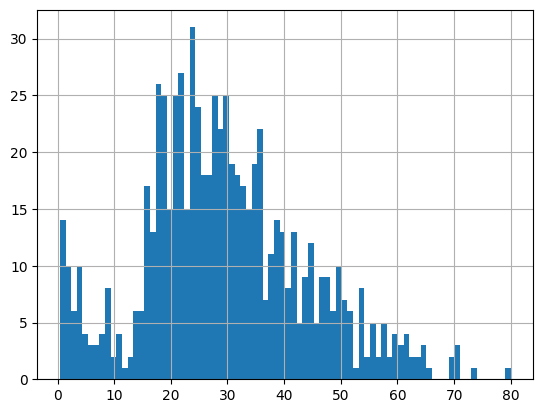

In [13]:
df["Age"].hist(bins=80)

Age: impute using median, because age has a skewed distribution and median is robust to outliers.

Embarked: impute using most frequent category, because NA is rare and categorical.


## 6. DP3 – Structure (Categoricals -> Numbers)

DP3 is about considering and narrowing options, not executing or finalising them. Hence at this stage you should:
* identify which variables are categorical
* inspect their values
* consider possible encoding options

### Exercise DP-3

Using the features selected in DP1, carry out the following four steps:

* Step 1: Recall features selected in DP1
* Step 2: Classify features as numeric vs categorical
* Step 3: Inspect the categorical variables (find out how many of each class is in the variable)
* Step 4: Conclude what kind of variables they are
* Step 5: what encoding options are appropriate





#### Step 1: Recall features selected in DP1

From DP1, the selected features are:

> Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

#### Step 2: Classify features as numeric vs categorical

Numeric features
* Age: continuous numeric
* Fare: continuous numeric
* SibSp: discrete numeric (count)
* Parch: discrete numeric (count)

Categorical features
* Sex: categorical (nominal)
* Embarked: categorical (nominal)
* Pclass: categorical (ordinal, even though stored as integers)

Important note:
Pclass is numeric in storage (int), but categorical in meaning.

#### Step 3: Inspect the categorical variables


In [14]:
# Inspect categorical variables: counts and percentages (including missing)
for col in categorical_features:
    print(f"--- {col} ---")
    counts = X[col].value_counts(dropna=False)
    pct = X[col].value_counts(normalize=True, dropna=False) * 100
    summary = pd.concat([counts, pct], axis=1)
    summary.columns = ['count', 'percent']
    # For Pclass keep natural order if numeric-like
    if col == 'Pclass':
        summary = summary.sort_index()
    print(summary)
    print(f"n_unique (excluding NaN): {X[col].nunique(dropna=True)}, missing: {X[col].isnull().sum()}\n")

--- Pclass ---
        count    percent
Pclass                  
1         216  24.242424
2         184  20.650954
3         491  55.106622
n_unique (excluding NaN): 3, missing: 0

--- Sex ---
        count    percent
Sex                     
male      577  64.758698
female    314  35.241302
n_unique (excluding NaN): 2, missing: 0

--- Embarked ---
          count    percent
Embarked                  
S           644  72.278339
C           168  18.855219
Q            77   8.641975
NaN           2   0.224467
n_unique (excluding NaN): 3, missing: 2



#### Step 4: Conclude what kind of variables they are

**Sex**
* Two categories: male, female
* No ordering
* No rare categories

Conclusion: nominal categorical variable.

**Embarked**
* Three categories: S, C, Q
* Some categories are much less frequent
* May contain missing values

Conclusion: nominal categorical variable with rare values.

**Pclass**
* Values: 1, 2, 3
* Clear ordering (1st > 2nd > 3rd class)

Conclusion: ordinal categorical variable.

#### Step 5: what encoding options are appropriate

**Sex**
Sex is a nominal categorical variable (no natural ordering).

Therefore, encodings that impose an artificial order (e.g. label encoding) are inappropriate.

Suitable options include one-hot encoding.

**Embarked**

Embarked is a nominal categorical variable with a small number of categories.

Suitable options include one-hot encoding.

**Pclass**

Pclass is an ordinal categorical variable (1st < 2nd < 3rd class).

Suitable options include ordinal encoding or one-hot encoding.


## 7. DP4 – Construct

We will engineer only these two features here:

- `FamilySize = SibSp + Parch + 1`
- `IsAlone = (FamilySize == 1)`

### Exercise DP-4

Create `X_fe` with the two new features.  
Then re-run the **same modelling & evaluation loop** (same model depth, same split seed).
Compare accuracy against baseline.


Accuracy (with engineered features): 0.7989    (baseline: 0.7989)

Confusion Matrix:
[[92 13]
 [23 51]]


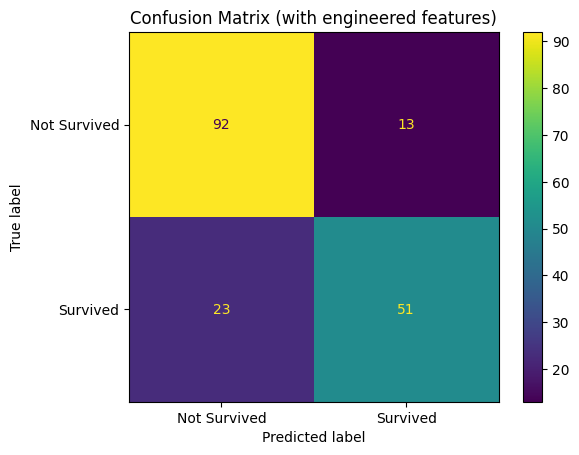


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [15]:
# Create feature-engineered dataset
X_fe = X.copy()
X_fe['FamilySize'] = X_fe['SibSp'] + X_fe['Parch'] + 1
X_fe['IsAlone'] = (X_fe['FamilySize'] == 1).astype(int)

# Train/test split (same seed as baseline)
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y, test_size=0.2, random_state=RANDOM_STATE
)

# Preprocessing + model pipeline (include new numeric features)
numerical_features_fe = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']
categorical_features_fe = ['Pclass', 'Sex', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_fe = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features_fe),
    ('cat', categorical_transformer, categorical_features_fe)
])

pipeline_fe = Pipeline(steps=[
    ('preprocessor', preprocessor_fe),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE))
])

# Fit and evaluate
pipeline_fe.fit(X_train_fe, y_train_fe)
y_pred_fe = pipeline_fe.predict(X_test_fe)

accuracy_fe = accuracy_score(y_test_fe, y_pred_fe)
conf_matrix_fe = confusion_matrix(y_test_fe, y_pred_fe)

print(f"Accuracy (with engineered features): {accuracy_fe:.4f}    (baseline: {accuracy:.4f})")
print("\nConfusion Matrix:")
print(conf_matrix_fe)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix_fe, display_labels=['Not Survived', 'Survived']).plot()
plt.title('Confusion Matrix (with engineered features)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_fe, y_pred_fe))

* You may see a small improvement, no change, or even a drop.

* Important thing is this is the first time in this lab that we are changing something to the data.

* We change it because it becomes easier to understand when we see new data generated.

* We are not optimising the model yet.


## 8. DP5 – Validate (Leakage + Stability Check)

Run the same experiment across a few random seeds and report the accuracy range.

In [17]:
# Run the same experiment across multiple random seeds to check stability
seeds = [42, 123, 456, 789, 1010, 1111, 2222, 3333, 4444, 5555]
accuracies = []

print("Running DP5 Validation across multiple random seeds:\n")
print(f"{'Seed':<10} {'Accuracy':<12}")
print("-" * 22)

for seed in seeds:
    # Split with different seed
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
        X_fe, y, test_size=0.2, random_state=seed
    )
    
    # Create and train pipeline with same structure but different seed
    numerical_features_fe = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']
    categorical_features_fe = ['Pclass', 'Sex', 'Embarked']
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor_val = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features_fe),
        ('cat', categorical_transformer, categorical_features_fe)
    ])
    
    pipeline_val = Pipeline(steps=[
        ('preprocessor', preprocessor_val),
        ('classifier', DecisionTreeClassifier(max_depth=3, random_state=seed))
    ])
    
    # Train and predict
    pipeline_val.fit(X_train_val, y_train_val)
    y_pred_val = pipeline_val.predict(X_test_val)
    
    accuracy_val = accuracy_score(y_test_val, y_pred_val)
    accuracies.append(accuracy_val)
    
    print(f"{seed:<10} {accuracy_val:<12.4f}")

print("-" * 22)
print(f"\n{'Accuracy Statistics:':<20}")
print(f"{'Min':<20} {min(accuracies):.4f}")
print(f"{'Max':<20} {max(accuracies):.4f}")
print(f"{'Mean':<20} {np.mean(accuracies):.4f}")
print(f"{'Std Dev':<20} {np.std(accuracies):.4f}")
print(f"{'Range':<20} {max(accuracies) - min(accuracies):.4f}")


Running DP5 Validation across multiple random seeds:

Seed       Accuracy    
----------------------
42         0.7989      
123        0.8547      
456        0.8156      
789        0.8492      
1010       0.8045      
1111       0.8380      
2222       0.7989      
3333       0.8156      
4444       0.7933      
5555       0.7598      
----------------------

Accuracy Statistics:
Min                  0.7598
Max                  0.8547
Mean                 0.8128
Std Dev              0.0272
Range                0.0950


If accuracy varies a lot across splits, this may mean: small dataset, noisy signal, or high variance model behaviour.



## 9. Optional: View the tree!

We keep the tree shallow to make rules visible.


* pipe2: full preprocessing + model pipeline
* pre: preprocessing step
* tree: trained decision tree
* ohe: trained one-hot encoder
* feature names: reconstructed for interpretation

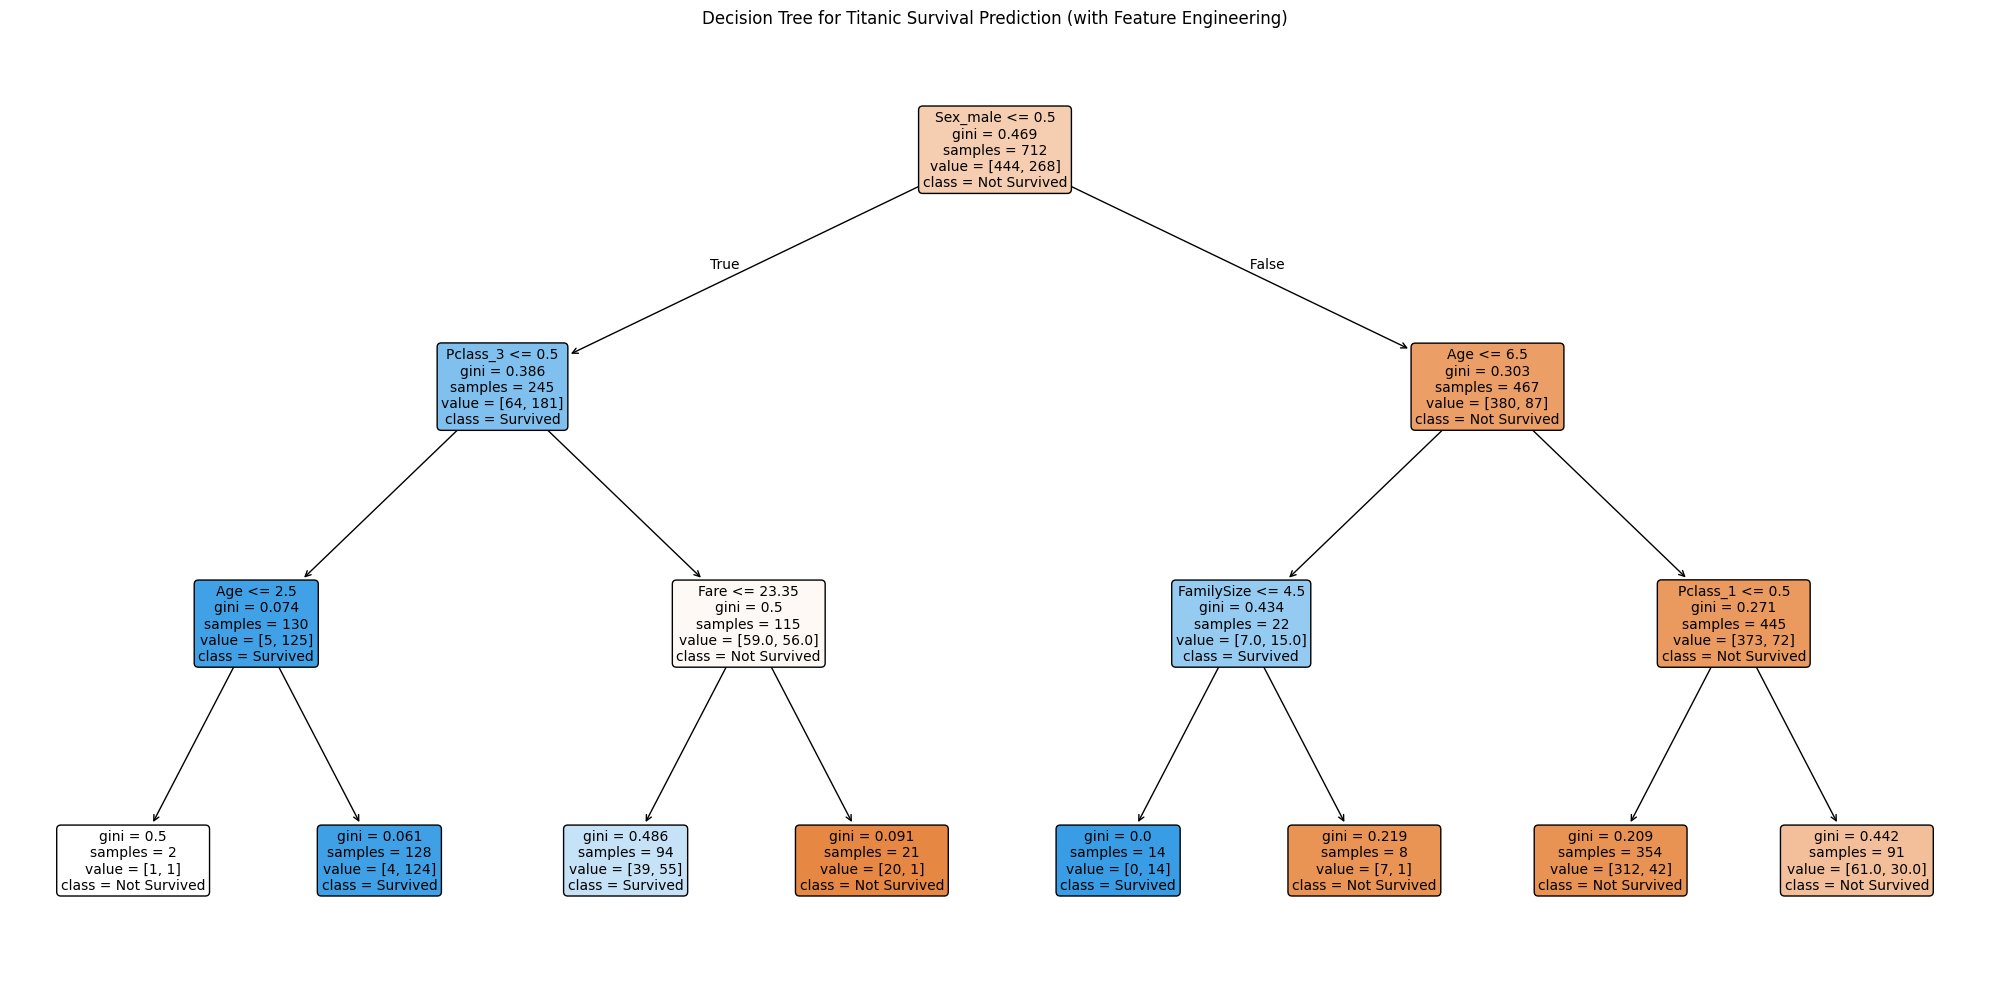

Tree depth: 3
Number of leaves: 8


In [18]:
# Extract components from the pipeline
preprocessor = pipeline_fe.named_steps['preprocessor']
tree_model = pipeline_fe.named_steps['classifier']

# Get feature names after preprocessing
numerical_features_list = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']
categorical_features_list = ['Pclass', 'Sex', 'Embarked']

# Get one-hot encoded feature names from the categorical transformer
cat_transformer = preprocessor.named_transformers_['cat']
ohe = cat_transformer.named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features_list).tolist()

# Combine all feature names
all_feature_names = numerical_features_list + ohe_feature_names

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=all_feature_names, 
          class_names=['Not Survived', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree for Titanic Survival Prediction (with Feature Engineering)')
plt.tight_layout()
plt.show()

# Print tree depth and node count for reference
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")



Important point is to always **Split first:** If you compute imputations/encodings on all data, you leak information from test into train and inflate the metric.

For example, when imputing `Age` using the mean/median computed from the full dataset (train+test) before splitting, you are leaking information from the test data into the train data.

# Task
Implement a scikit-learn pipeline for baseline modeling on the Titanic dataset, including: splitting data into training and testing sets (20% test size) using `RANDOM_STATE`, preprocessing numerical features (`Age`, `Fare`, `SibSp`, `Parch`) with median imputation, and categorical features (`Pclass`, `Sex`, `Embarked`) with most frequent imputation and one-hot encoding. Then, train a `DecisionTreeClassifier` with `max_depth=3` and `random_state=RANDOM_STATE`. Finally, evaluate and report the accuracy score, confusion matrix, and classification report on the test set, all within a single code cell.

## Implement Baseline Model

### Subtask:
Build a scikit-learn pipeline for baseline modeling. This involves splitting the data into training and testing sets (using `RANDOM_STATE`), preprocessing numerical features with median imputation, categorical features with most frequent imputation and one-hot encoding, and training a Decision Tree Classifier with a `max_depth` of 3. Finally, evaluate the model by reporting accuracy and a confusion matrix on the test set. All steps are encapsulated within a single code cell to establish the baseline.


## Summary:

### Data Analysis Key Findings
*   A scikit-learn pipeline was successfully implemented to establish a baseline model for predicting survival on the Titanic dataset.
*   The data was split into training and testing sets, with 80% used for training and 20% for testing.
*   Numerical features (`Age`, `Fare`, `SibSp`, `Parch`) were preprocessed using median imputation to handle missing values.
*   Categorical features (`Pclass`, `Sex`, `Embarked`) were preprocessed using most frequent imputation for missing values, followed by one-hot encoding.
*   A `DecisionTreeClassifier` with a `max_depth` of 3 was trained as the baseline model.
*   The model's performance on the test set was evaluated, reporting accuracy, a confusion matrix, and a classification report.

### Insights or Next Steps
*   The baseline model provides a fundamental understanding of the dataset's predictability. The reported accuracy serves as a benchmark for future, more complex models.
*   Further steps should focus on hyperparameter tuning for the Decision Tree Classifier, exploring other machine learning algorithms (e.g., Random Forest, Gradient Boosting), and potentially engineering new features from the existing data to improve predictive performance.
